In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import pymc3 as pm

Could not import matplotlib.animation 'ascii' codec can't decode byte 0xc2 in position 90: ordinal not in range(128)


In [2]:
N_GALS = 296
MU_N_ARMS = 2
MU_PHI = 20
SD_PHI = 10
SD_GAL = 10
LOWER_BOUND = 0
UPPER_BOUND = 90

In [3]:
base_dist = st.truncnorm(
    (LOWER_BOUND - MU_PHI) / SD_PHI,
    (UPPER_BOUND - MU_PHI) / SD_PHI,
    loc=MU_PHI, scale=SD_PHI
)
n_arms = st.poisson(MU_N_ARMS)

Text(0.5, 1.0, 'Distribution of galaxy pitch angles')

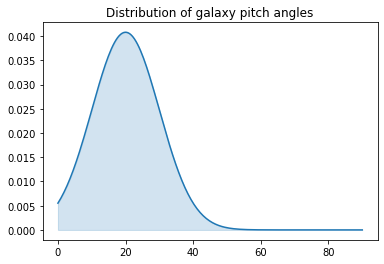

In [4]:
x = np.linspace(0, 90, 200)
y = base_dist.pdf(x)
plt.plot(x, y)
plt.fill_between(x, y, color='C0', alpha=0.2)
plt.title('Distribution of galaxy pitch angles')

In [5]:
true_gal_pas = base_dist.rvs(N_GALS)
gal_n_arms = st.poisson(MU_N_ARMS).rvs(N_GALS)

In [6]:
def get_arms(n_arms, gal_pa):
    return st.truncnorm(
        (LOWER_BOUND - gal_pa) / SD_GAL,
        (UPPER_BOUND - gal_pa) / SD_GAL,
        loc=gal_pa, scale=SD_GAL
    ).rvs(n_arms)
gals = np.array([get_arms(n, phi) for n, phi in zip(gal_n_arms, true_gal_pas)])

In [7]:
# restrict to galaxies with 1 or more arms?
gal_n_arm_mask = np.fromiter((len(i) >= 0 for i in gals), dtype=bool)
gals = gals[gal_n_arm_mask]
masked_true_gal_pas = true_gal_pas[gal_n_arm_mask]
gal_arm_map = np.concatenate([
    np.tile(i, n) for i, n in enumerate(map(len, gals))
])
arms = np.concatenate(gals)

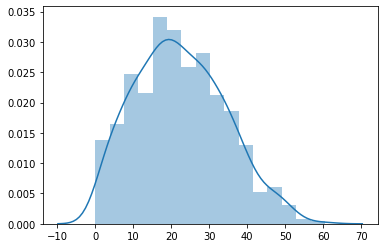

In [8]:
sns.distplot(arms)

In [9]:
with pm.Model() as model:
    # Global mean pitch angle
    mu_phi = pm.Uniform(
        'mu_phi',
        lower=0, upper=90
    )
    # inter-galaxy dispersion
    sigma_phi = pm.InverseGamma(
        'sigma_phi', alpha=2, beta=15, testval=8
    )
    # intra-galaxy dispersion
    sigma_gal = pm.InverseGamma(
        'sigma_gal', alpha=2, beta=15, testval=8
    )
    phi_gal = pm.TruncatedNormal(
        'phi_gal',
        mu=mu_phi, sd=sigma_phi,
        lower=0, upper=90, shape=len(gals),
    )
    # arm offset parameter
    phi_arm = pm.TruncatedNormal(
        'phi_arm',
        mu=phi_gal[gal_arm_map], sd=sigma_gal,
        lower=0, upper=90, observed=arms
    )

In [10]:
with model:
    trace = pm.sample(2000, init='advi+adapt_diag', target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 2,352.4:  10%|█         | 20995/200000 [00:32<04:35, 650.70it/s]
Convergence achieved at 21000
Interrupted at 20,999 [10%]: Average Loss = 3,168.2
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [phi_gal, sigma_gal, sigma_phi, mu_phi]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:58<00:00, 42.03draws/s]
The number of effective samples is smaller than 25% for some parameters.


Let's calculate the values we'd get for the _"length-weighted mean pitch angle"_ (assuming all arms are the same length)

In [11]:
mean_pas = pd.Series(gals).apply(np.mean)
std_pas =  pd.Series(gals).apply(np.std)

/Users/tlingard/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tlingard/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


Text(0.5, 0, 'Mean galaxy pitch angle')

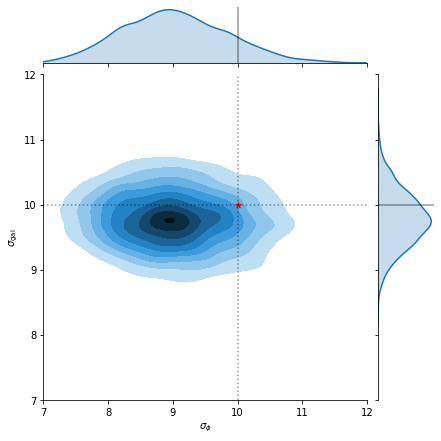

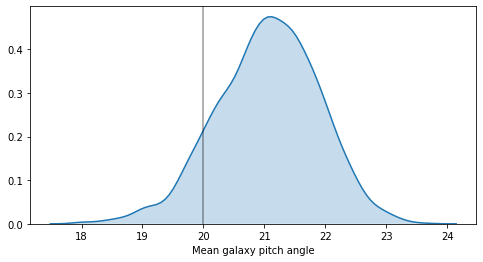

In [12]:
g = sns.jointplot(
    trace['sigma_phi'], trace['sigma_gal'],
    kind='kde', joint_kws=dict(shade_lowest=False),
    xlim=(7, 12), ylim=(7,  12)
)
g.ax_joint.scatter(SD_PHI, SD_GAL, marker='*', color='r')
g.ax_joint.axvline(SD_PHI, color='k', ls=':', alpha=0.4)
g.ax_joint.axhline(SD_GAL, color='k', ls=':', alpha=0.4)
g.ax_marg_x.axvline(SD_PHI, color='k', alpha=0.4)
g.ax_marg_y.axhline(SD_GAL, color='k', alpha=0.4)
g.ax_joint.set_xlabel(r'$\sigma_\phi$')
g.ax_joint.set_ylabel(r'$\sigma_\mathrm{gal}$')

plt.figure(figsize=(8, 4))
sns.kdeplot(trace['mu_phi'], shade=True)
plt.axvline(MU_PHI, color='k', alpha=0.4, label='True value')
plt.xlabel('Mean galaxy pitch angle')

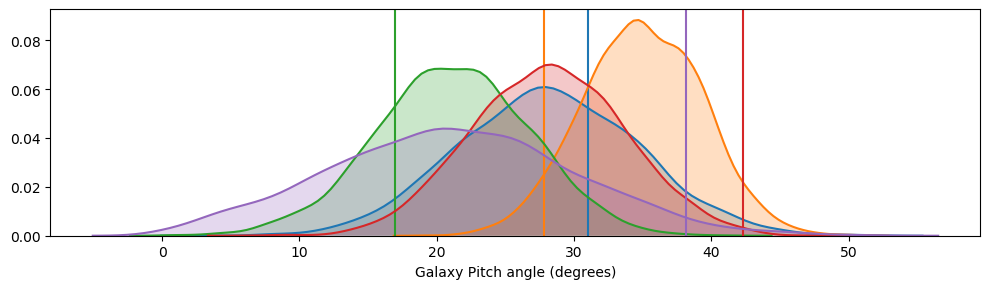

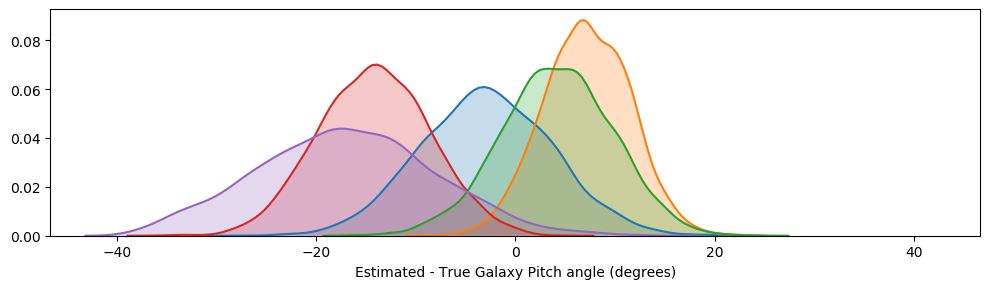

In [13]:
sample_idx = np.random.choice(np.arange(trace['phi_gal'].shape[1]), 5, replace=False)
plt.figure(figsize=(12, 3), dpi=100)
for i, idx in enumerate(sample_idx):
    sns.kdeplot((trace['phi_gal'][:, idx]), shade=True, color=f'C{i}')
    plt.axvline(masked_true_gal_pas[idx], color=f'C{i}')
plt.xlabel('Galaxy Pitch angle (degrees)')

plt.figure(figsize=(12, 3), dpi=100)
for i, idx in enumerate(sample_idx):
    sns.kdeplot((trace['phi_gal'][:, idx] - masked_true_gal_pas[idx]), shade=True, color=f'C{i}')
plt.xlabel('Estimated - True Galaxy Pitch angle (degrees)')
l = np.abs(plt.xlim()).max()
plt.xlim(-l, l);

In [14]:
sample_idx = np.random.choice(np.arange(trace['phi_gal'].shape[1]), 25, replace=False)

Text(27.125, 0.5, 'Posterior Mean')

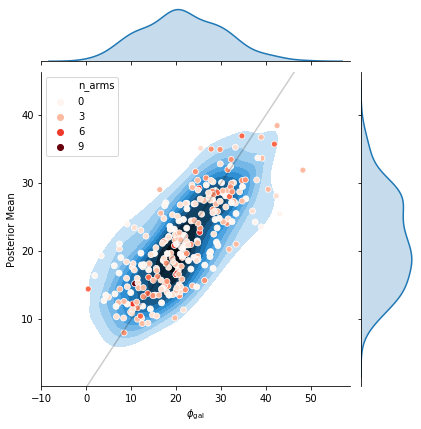

In [15]:
df = pd.concat((
    pd.Series(masked_true_gal_pas).rename('true'),
    pd.Series(trace['phi_gal'].mean(axis=0)).rename('estimate'),
    pd.Series(trace['phi_gal'].std(axis=0)).rename('err'),
    pd.Series(mean_pas).rename('mean'),
    pd.Series(np.fromiter(map(len, gals), dtype=int)).rename('n_arms')
), axis=1)
g = sns.jointplot('true', 'estimate', data=df.dropna(), kind='kde', joint_kws=dict(shade_lowest=False))
plt.sca(g.ax_joint)
sns.scatterplot(x='true', y='estimate', data=df.dropna(), hue='n_arms', palette="Reds")
g.ax_joint.add_line(plt.Line2D((0, 90), (0, 90), color='k', alpha=0.2))
g.ax_joint.set_xlabel(r'$\phi_\mathrm{gal}$')
g.ax_joint.set_ylabel('Posterior Mean')

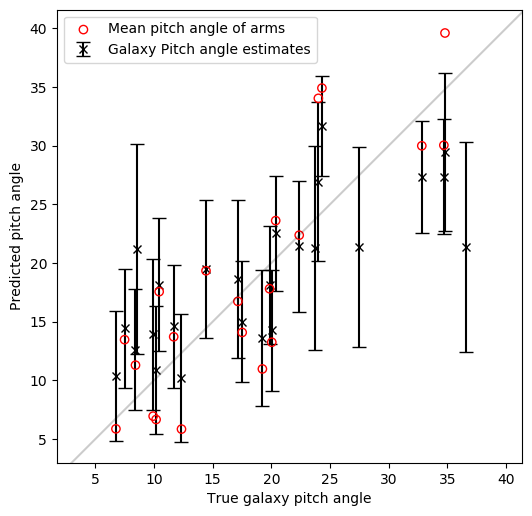

In [16]:
plt.figure(figsize=(6, 6), dpi=100)
plt.errorbar(
    masked_true_gal_pas[sample_idx],
    trace['phi_gal'][:, sample_idx].mean(axis=0),
    yerr=trace['phi_gal'][:, sample_idx].std(axis=0),
    fmt='x', capsize=5,
    zorder=1,
    c='k'
)
plt.errorbar([], [], yerr=1, fmt='x', capsize=5, c='k', label='Galaxy Pitch angle estimates')
plt.scatter(
    masked_true_gal_pas[sample_idx],
    mean_pas[sample_idx],
    fc='none', ec='r', zorder=2,
    label='Mean pitch angle of arms'
)
plt.axis('equal')
plt.gca().add_line(plt.Line2D((0, 90), (0, 90), color='k', alpha=0.2))
plt.xlabel('True galaxy pitch angle')
plt.ylabel('Predicted pitch angle')
plt.legend()

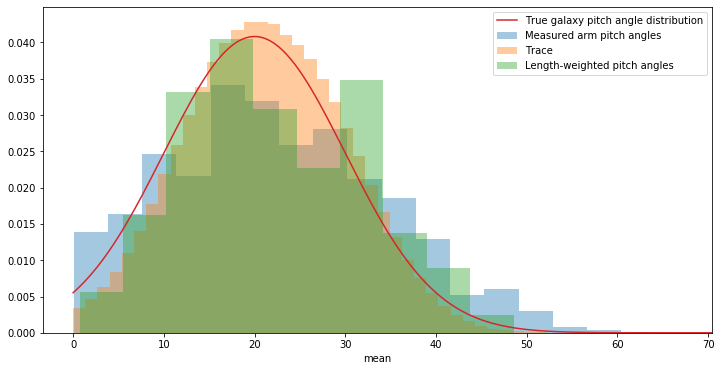

In [17]:
plt.figure(figsize=(12, 6))
sns.distplot(arms, label='Measured arm pitch angles', kde=False, norm_hist=True)
sns.distplot(trace['phi_gal'].ravel(), label='Trace', kde=False, norm_hist=True)
sns.distplot(df.dropna()['mean'], label='Length-weighted pitch angles', kde=False, norm_hist=True)
l = plt.xlim()
plt.plot(x, y, label='True galaxy pitch angle distribution')
plt.xlim(*l)
plt.legend()

One easy way 

In [18]:
mse_trace = np.sqrt(np.sum((masked_true_gal_pas - trace['phi_gal'].mean(axis=0))**2)) / len(masked_true_gal_pas)
mse_mean = np.sqrt(np.sum(pd.Series(masked_true_gal_pas - mean_pas).dropna()**2)) / len(masked_true_gal_pas)
print(f'RMSE trace expectation: {mse_trace:.4f}')
print(f'RMSE length-weighted:   {mse_mean:.4f}')

RMSE trace expectation: 0.3897
RMSE length-weighted:   0.3771
